In [1]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

# model_dir = './models/'
model_file = 'vit_brain_mri.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip -o /content/drive/MyDrive/dataset_19.zip

! pwd

Archive:  /content/drive/MyDrive/dataset_19.zip
   creating: dataset_19/glioma/
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflat

# Load the Data

In [4]:
# Data Directories
dir = "dataset_19/"
validation_dir = "Testing"

# Data Distribution

In [5]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

notumor       120
glioma        120
pituitary     120
meningioma    120
dtype: int64

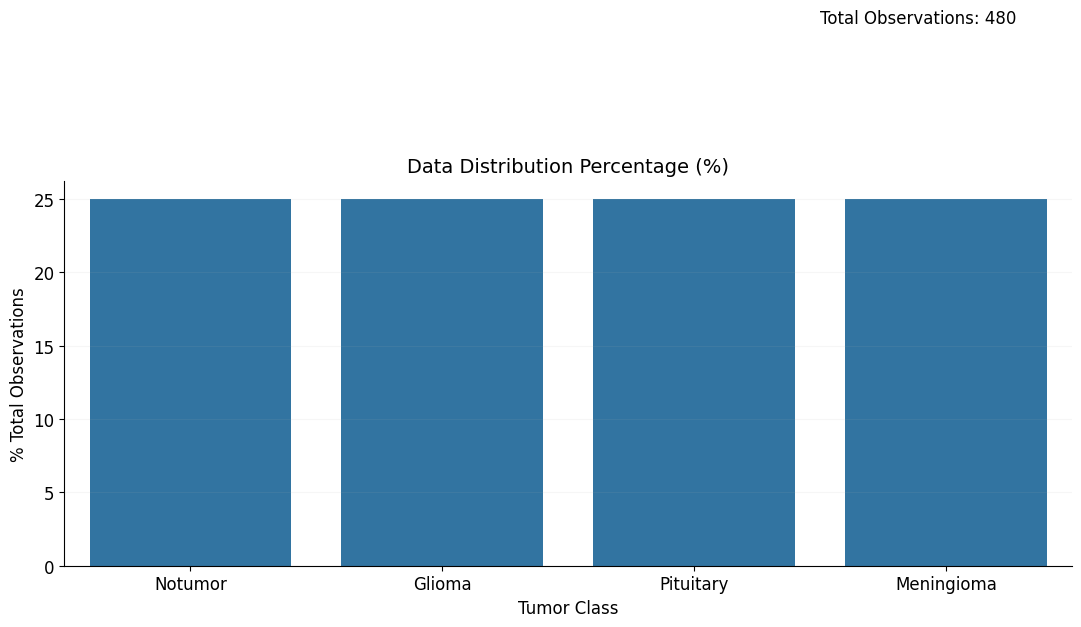

In [6]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Preprocess the Data

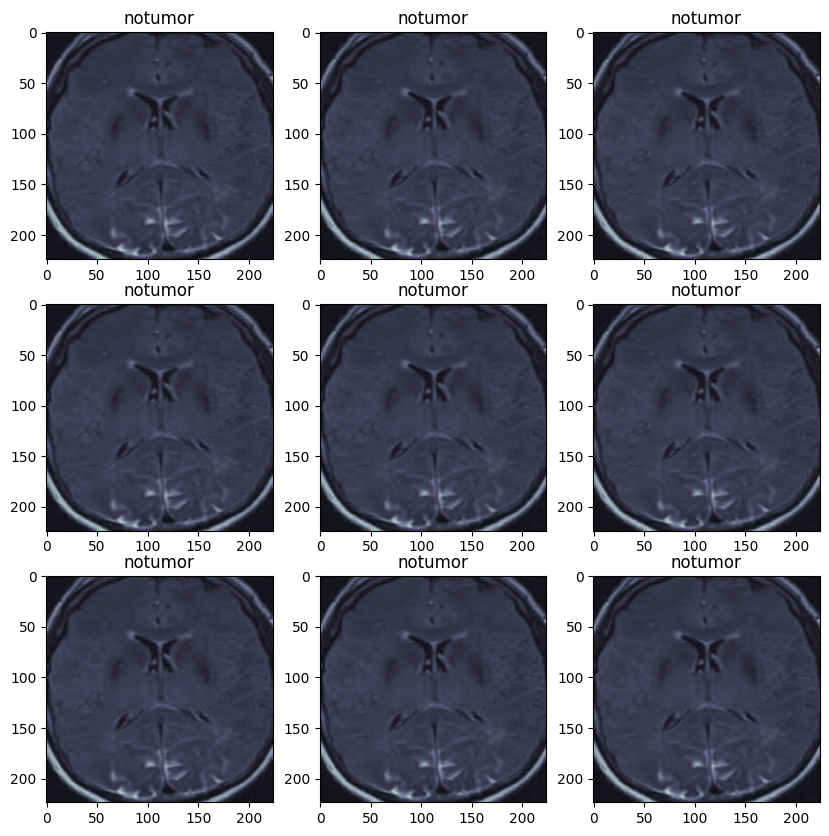

In [7]:
from tqdm import tqdm
import cv2
import imutils

def crop_img(img):

  # Find extreme points on the image and crop the rectangular out

  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gray = cv2.GaussianBlur(gray, (3, 3), 0)

  # threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  # find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  ADD_PIXELS = 0
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

  return new_img

def preprocess_images(directory):
    for dir in os.listdir(directory):
        path = os.path.join(directory, dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            cropped_img = crop_img(img)
            processed_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
            processed_img = cv2.bilateralFilter(processed_img, 2, 50, 50)
            processed_img = cv2.applyColorMap(processed_img, cv2.COLORMAP_BONE)
            processed_img = cv2.resize(processed_img, (224, 224))
            cv2.imwrite(img_path, processed_img)


# Preprocess the images before generating data
preprocess_images(dir)

# Display 9 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for curr_index in os.listdir(dir):
        path = os.path.join(dir, curr_index)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            image = plt.imread(img_path)
            plt.imshow(image)
            plt.title(curr_index)
            break
        break

# Splitting the Data

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


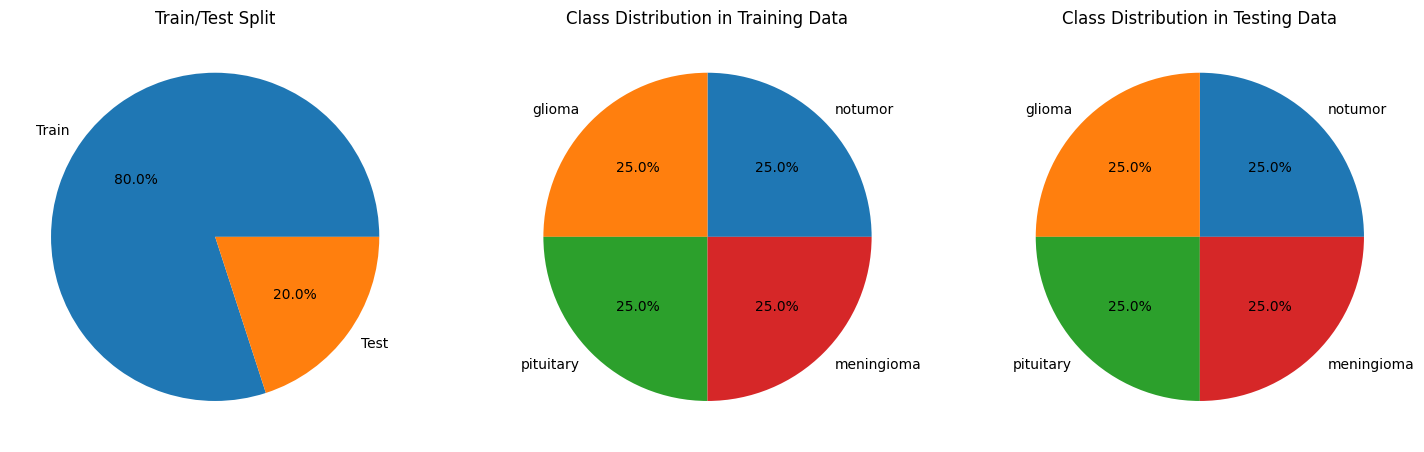

In [8]:
classes = os.listdir(dir)
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='validation')


print(test_generator.class_indices)

# Get the number of samples in the training and testing data
num_train_samples = train_generator.samples
num_test_samples = test_generator.samples

# Get the distribution of classes in the training and testing data
train_class_distribution = np.bincount(train_generator.classes)
test_class_distribution = np.bincount(test_generator.classes)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the train/test split
axes[0].pie([num_train_samples, num_test_samples], labels=['Train', 'Test'], autopct='%1.1f%%')
axes[0].set_title('Train/Test Split')

# Plot the distribution of classes in the training data
axes[1].pie(train_class_distribution, labels=classes, autopct='%1.1f%%')
axes[1].set_title('Class Distribution in Training Data')

# Plot the distribution of classes in the testing data
axes[2].pie(test_class_distribution, labels=classes, autopct='%1.1f%%')
axes[2].set_title('Class Distribution in Testing Data')

# Display the plots
plt.show()

# To Check Data Loading and Augmentation


In [9]:
print(train_generator.class_indices)
print(test_generator.class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Installing TensorFlow Addon and vit-keras Package

In [10]:
! pip install tensorflow-addons vit-keras
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 14.4 MB/s eta 0:00:00


# Training a Vision Transformer (ViT) model



In [11]:
from transformers import ViTForImageClassification, ViTConfig, ViTModel
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from vit_keras import vit, layers
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import optuna
from tensorflow.keras.regularizers import l2


# # Function to create ViT model
# def create_vit_model(input_shape, num_classes, learning_rate, dropout_rate, l2_reg):
#     vit_model = vit.vit_b16(
#         image_size=224,
#         pretrained=True,
#         include_top=True,
#         pretrained_top=False,
#         classes=num_classes
#     )

#     inputs = Input(shape=input_shape, dtype=tf.float32)
#     outputs = vit_model(inputs)
#     outputs = Dropout(dropout_rate)(outputs)  # Use variable dropout rate
#     outputs = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg))(outputs)
#     model = Model(inputs, outputs)
#     model = Model(inputs, outputs)
#     model.compile(optimizer=Adam(learning_rate=learning_rate),  # Use variable learning rate
#                   loss=CategoricalCrossentropy(from_logits=True),
#                   metrics=['accuracy'])
#     return model


## *** BETTER LEARNING CURVE BUT BAD CM ***

# def create_vit_model(input_shape, num_classes, learning_rate, dropout_rate, l2_reg):
#     # Load the pretrained ViT model
#     vit_model = vit.vit_b16(
#         image_size=224,
#         activation='softmax',
#         pretrained=True,
#         include_top=False,
#         pretrained_top=False,
#         classes=num_classes
#     )

#     # Freeze the pretrained layers
#     for layer in vit_model.layers:
#         layer.trainable = False  # Freezing the layer

#     # Create new input layer
#     inputs = Input(shape=input_shape, dtype=tf.float32)
#     # Pass inputs through the ViT model
#     x = vit_model(inputs)

#     # Add new layers
#     x = Dropout(dropout_rate)(x)  # Use variable dropout rate
#     x = Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)

#     # Create the final model
#     model = Model(inputs=inputs, outputs=x)
#     model.compile(optimizer=Adam(learning_rate=learning_rate),
#                   loss=CategoricalCrossentropy(from_logits=True),
#                   metrics=['accuracy'])
#     return model

# Function to create ViT model
def create_vit_model(input_shape, num_classes, learning_rate, dropout_rate):
    vit_model = vit.vit_b16(
        image_size=224,
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
        classes=num_classes
    )

    # Unfreeze the top layers of the pretrained ViT model
    for layer in vit_model.layers[-3:]:  # Unfreeze the last 3 layers, adjust as needed
        layer.trainable = True

    inputs = Input(shape=input_shape, dtype=tf.float32)
    x = vit_model(inputs)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

# Define the objective function for Optuna
def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)

    model = create_vit_model((224, 224, 3), len(classes), learning_rate, dropout_rate)

    checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')  # Reduced patience
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)  # Reduced patience

    class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
    class_weights = {i: class_weights[i] for i in range(len(class_weights))}

    # Run fewer epochs for initial trials
    initial_epochs = 15

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=initial_epochs,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        class_weight=class_weights
    )

    model.load_weights(model_file)
    trial.set_user_attr('history', history.history)
    val_loss = model.evaluate(test_generator, steps=test_generator.samples // batch_size, verbose=0)[0]

    return val_loss

# Run Optuna optimization with fewer epochs
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Best trial results
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

history = trial.user_attrs['history']

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
[I 2024-06-09 07:37:23,728] A new study created in memory with name: no-name-fe1f7028-21b4-4cdc-a9b1-a4d1a49a4e00
<ipython-input-11-a7863f206187>:167: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-a7863f206187>:168: FutureWarning: sug

347502902/347502902 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - ETA: 0s - loss: 1.8643 - accuracy: 0.3411
Epoch 1: val_loss improved from inf to 0.99999, saving model to vit_brain_mri.keras
24/24 [==============================] - 60s 673ms/step - loss: 1.8643 - accuracy: 0.3411 - val_loss: 1.0000 - val_accuracy: 0.5208 - lr: 3.1262e-04
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 1.2621 - accuracy: 0.5130
Epoch 2: val_loss improved from 0.99999 to 0.94001, saving model to vit_brain_mri.keras
24/24 [==============================] - 13s 524ms/step - loss: 1.2621 - accuracy: 0.5130 - val_loss: 0.9400 - val_accuracy: 0.6354 - lr: 3.1262e-04
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 0.8306 - accuracy: 0.6797
Epoch 3: val_loss did not improve from 0.94001
24/24 [==============================] - 9s 351ms/step - loss: 0.8306 - accuracy: 0.6797 - val_loss: 1.3222 - val_accuracy: 0.6250 - lr: 3.1262e-04
Epoch 4/15
24/24 [==============================] - ETA: 0s - lo

[I 2024-06-09 07:45:46,387] Trial 0 finished with value: 0.3505561053752899 and parameters: {'learning_rate': 0.00031261833021022263, 'dropout_rate': 0.4316389807231171}. Best is trial 0 with value: 0.3505561053752899.
<ipython-input-11-a7863f206187>:167: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-a7863f206187>:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - ETA: 0s - loss: 1.3372 - accuracy: 0.4844
Epoch 1: val_loss improved from inf to 0.87586, saving model to vit_brain_mri.keras
24/24 [==============================] - 55s 649ms/step - loss: 1.3372 - accuracy: 0.4844 - val_loss: 0.8759 - val_accuracy: 0.6250 - lr: 5.9106e-05
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 0.7425 - accuracy: 0.7422
Epoch 2: val_loss did not improve from 0.87586
24/24 [==============================] - 9s 366ms/step - loss: 0.7425 - accuracy: 0.7422 - val_loss: 1.1403 - val_accuracy: 0.6562 - lr: 5.9106e-05
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 0.3574 - accuracy: 0.8620
Epoch 3: val_loss did not improve from 0.87586
24/24 [==============================] - 9s 367ms/step - loss: 0.3574 - accuracy: 0.8620 - val_loss: 0.9266 - val_accuracy: 0.7083 - lr: 5.9106e-05
Epoch 4/15
24/24 [==============================] - ETA: 0s - loss: 0.3763 - accuracy: 0.8698
Epoch 4: val

[I 2024-06-09 07:54:13,702] Trial 1 finished with value: 0.540280282497406 and parameters: {'learning_rate': 5.910563389035537e-05, 'dropout_rate': 0.44573579813301883}. Best is trial 0 with value: 0.3505561053752899.
<ipython-input-11-a7863f206187>:167: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-a7863f206187>:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - ETA: 0s - loss: 1.2214 - accuracy: 0.5365
Epoch 1: val_loss improved from inf to 0.82365, saving model to vit_brain_mri.keras
24/24 [==============================] - 55s 658ms/step - loss: 1.2214 - accuracy: 0.5365 - val_loss: 0.8237 - val_accuracy: 0.6979 - lr: 3.5270e-05
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 0.6460 - accuracy: 0.7370
Epoch 2: val_loss improved from 0.82365 to 0.73499, saving model to vit_brain_mri.keras
24/24 [==============================] - 14s 594ms/step - loss: 0.6460 - accuracy: 0.7370 - val_loss: 0.7350 - val_accuracy: 0.7396 - lr: 3.5270e-05
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 0.4381 - accuracy: 0.8385
Epoch 3: val_loss did not improve from 0.73499
24/24 [==============================] - 9s 368ms/step - loss: 0.4381 - accuracy: 0.8385 - val_loss: 0.7535 - val_accuracy: 0.7604 - lr: 3.5270e-05
Epoch 4/15
24/24 [==============================] - ETA: 0s - lo

[I 2024-06-09 08:02:21,484] Trial 2 finished with value: 0.4526207149028778 and parameters: {'learning_rate': 3.527045307668553e-05, 'dropout_rate': 0.3065407254009425}. Best is trial 0 with value: 0.3505561053752899.
<ipython-input-11-a7863f206187>:167: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-a7863f206187>:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - ETA: 0s - loss: 1.3782 - accuracy: 0.5391
Epoch 1: val_loss improved from inf to 0.74950, saving model to vit_brain_mri.keras
24/24 [==============================] - 55s 650ms/step - loss: 1.3782 - accuracy: 0.5391 - val_loss: 0.7495 - val_accuracy: 0.7188 - lr: 1.7833e-04
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 0.6789 - accuracy: 0.7526
Epoch 2: val_loss did not improve from 0.74950
24/24 [==============================] - 9s 365ms/step - loss: 0.6789 - accuracy: 0.7526 - val_loss: 1.1993 - val_accuracy: 0.6354 - lr: 1.7833e-04
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 0.4729 - accuracy: 0.8542
Epoch 3: val_loss improved from 0.74950 to 0.65277, saving model to vit_brain_mri.keras
24/24 [==============================] - 13s 530ms/step - loss: 0.4729 - accuracy: 0.8542 - val_loss: 0.6528 - val_accuracy: 0.7500 - lr: 1.7833e-04
Epoch 4/15
24/24 [==============================] - ETA: 0s - lo

[I 2024-06-09 08:10:45,109] Trial 3 finished with value: 0.3026972711086273 and parameters: {'learning_rate': 0.0001783263332116025, 'dropout_rate': 0.41118405783350986}. Best is trial 3 with value: 0.3026972711086273.
<ipython-input-11-a7863f206187>:167: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-a7863f206187>:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - ETA: 0s - loss: 1.8616 - accuracy: 0.3177
Epoch 1: val_loss improved from inf to 1.41456, saving model to vit_brain_mri.keras
24/24 [==============================] - 54s 649ms/step - loss: 1.8616 - accuracy: 0.3177 - val_loss: 1.4146 - val_accuracy: 0.2917 - lr: 4.0710e-04
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 1.3947 - accuracy: 0.4089
Epoch 2: val_loss improved from 1.41456 to 1.08813, saving model to vit_brain_mri.keras
24/24 [==============================] - 13s 528ms/step - loss: 1.3947 - accuracy: 0.4089 - val_loss: 1.0881 - val_accuracy: 0.5417 - lr: 4.0710e-04
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 1.0906 - accuracy: 0.5521
Epoch 3: val_loss improved from 1.08813 to 0.90015, saving model to vit_brain_mri.keras
24/24 [==============================] - 13s 529ms/step - loss: 1.0906 - accuracy: 0.5521 - val_loss: 0.9001 - val_accuracy: 0.5521 - lr: 4.0710e-04
Epoch 4/15
24/24 [====

[I 2024-06-09 08:19:14,746] Trial 4 finished with value: 0.5381636023521423 and parameters: {'learning_rate': 0.0004071020314412851, 'dropout_rate': 0.3818814188258372}. Best is trial 3 with value: 0.3026972711086273.
<ipython-input-11-a7863f206187>:167: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-a7863f206187>:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - ETA: 0s - loss: 1.3157 - accuracy: 0.4661
Epoch 1: val_loss improved from inf to 0.81516, saving model to vit_brain_mri.keras
24/24 [==============================] - 56s 651ms/step - loss: 1.3157 - accuracy: 0.4661 - val_loss: 0.8152 - val_accuracy: 0.7083 - lr: 2.5132e-05
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 0.7051 - accuracy: 0.7214
Epoch 2: val_loss improved from 0.81516 to 0.61246, saving model to vit_brain_mri.keras
24/24 [==============================] - 13s 525ms/step - loss: 0.7051 - accuracy: 0.7214 - val_loss: 0.6125 - val_accuracy: 0.7708 - lr: 2.5132e-05
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 0.5060 - accuracy: 0.8073
Epoch 3: val_loss improved from 0.61246 to 0.59469, saving model to vit_brain_mri.keras
24/24 [==============================] - 13s 526ms/step - loss: 0.5060 - accuracy: 0.8073 - val_loss: 0.5947 - val_accuracy: 0.7188 - lr: 2.5132e-05
Epoch 4/15
24/24 [====

[I 2024-06-09 08:28:01,020] Trial 5 finished with value: 0.3370884358882904 and parameters: {'learning_rate': 2.5132133149419553e-05, 'dropout_rate': 0.34818591008375105}. Best is trial 3 with value: 0.3026972711086273.
<ipython-input-11-a7863f206187>:167: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-a7863f206187>:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - ETA: 0s - loss: 1.5544 - accuracy: 0.3932
Epoch 1: val_loss improved from inf to 0.82857, saving model to vit_brain_mri.keras
24/24 [==============================] - 55s 646ms/step - loss: 1.5544 - accuracy: 0.3932 - val_loss: 0.8286 - val_accuracy: 0.6458 - lr: 2.3416e-05
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 0.9968 - accuracy: 0.6146
Epoch 2: val_loss improved from 0.82857 to 0.62447, saving model to vit_brain_mri.keras
24/24 [==============================] - 13s 525ms/step - loss: 0.9968 - accuracy: 0.6146 - val_loss: 0.6245 - val_accuracy: 0.7292 - lr: 2.3416e-05
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 0.5989 - accuracy: 0.7708
Epoch 3: val_loss improved from 0.62447 to 0.54729, saving model to vit_brain_mri.keras
24/24 [==============================] - 13s 533ms/step - loss: 0.5989 - accuracy: 0.7708 - val_loss: 0.5473 - val_accuracy: 0.7708 - lr: 2.3416e-05
Epoch 4/15
24/24 [====

[I 2024-06-09 08:36:11,323] Trial 6 finished with value: 0.3570094406604767 and parameters: {'learning_rate': 2.3415617240678825e-05, 'dropout_rate': 0.4364694361712328}. Best is trial 3 with value: 0.3026972711086273.
<ipython-input-11-a7863f206187>:167: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-a7863f206187>:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - ETA: 0s - loss: 1.3826 - accuracy: 0.5026
Epoch 1: val_loss improved from inf to 1.52404, saving model to vit_brain_mri.keras
24/24 [==============================] - 54s 648ms/step - loss: 1.3826 - accuracy: 0.5026 - val_loss: 1.5240 - val_accuracy: 0.5208 - lr: 1.9066e-04
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 0.6965 - accuracy: 0.7370
Epoch 2: val_loss improved from 1.52404 to 0.81061, saving model to vit_brain_mri.keras
24/24 [==============================] - 13s 527ms/step - loss: 0.6965 - accuracy: 0.7370 - val_loss: 0.8106 - val_accuracy: 0.7188 - lr: 1.9066e-04
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 0.4068 - accuracy: 0.8568
Epoch 3: val_loss improved from 0.81061 to 0.67692, saving model to vit_brain_mri.keras
24/24 [==============================] - 14s 587ms/step - loss: 0.4068 - accuracy: 0.8568 - val_loss: 0.6769 - val_accuracy: 0.8438 - lr: 1.9066e-04
Epoch 4/15
24/24 [====

[I 2024-06-09 08:44:17,983] Trial 7 finished with value: 0.3953784704208374 and parameters: {'learning_rate': 0.0001906598269302162, 'dropout_rate': 0.4957256351063726}. Best is trial 3 with value: 0.3026972711086273.
<ipython-input-11-a7863f206187>:167: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-a7863f206187>:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - ETA: 0s - loss: 1.7403 - accuracy: 0.3672
Epoch 1: val_loss improved from inf to 1.09446, saving model to vit_brain_mri.keras
24/24 [==============================] - 58s 736ms/step - loss: 1.7403 - accuracy: 0.3672 - val_loss: 1.0945 - val_accuracy: 0.5938 - lr: 1.7753e-05
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 1.0740 - accuracy: 0.6094
Epoch 2: val_loss improved from 1.09446 to 0.93138, saving model to vit_brain_mri.keras
24/24 [==============================] - 13s 530ms/step - loss: 1.0740 - accuracy: 0.6094 - val_loss: 0.9314 - val_accuracy: 0.6354 - lr: 1.7753e-05
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 0.8233 - accuracy: 0.6927
Epoch 3: val_loss did not improve from 0.93138
24/24 [==============================] - 9s 368ms/step - loss: 0.8233 - accuracy: 0.6927 - val_loss: 1.0294 - val_accuracy: 0.5938 - lr: 1.7753e-05
Epoch 4/15
24/24 [==============================] - ETA: 0s - lo

[I 2024-06-09 08:52:24,632] Trial 8 finished with value: 0.6292901635169983 and parameters: {'learning_rate': 1.775276504225729e-05, 'dropout_rate': 0.4796280862809396}. Best is trial 3 with value: 0.3026972711086273.
<ipython-input-11-a7863f206187>:167: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-a7863f206187>:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - ETA: 0s - loss: 2.2306 - accuracy: 0.2318
Epoch 1: val_loss improved from inf to 1.46005, saving model to vit_brain_mri.keras
24/24 [==============================] - 54s 644ms/step - loss: 2.2306 - accuracy: 0.2318 - val_loss: 1.4600 - val_accuracy: 0.2500 - lr: 5.0583e-04
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 1.5284 - accuracy: 0.3281
Epoch 2: val_loss improved from 1.46005 to 1.23033, saving model to vit_brain_mri.keras
24/24 [==============================] - 13s 523ms/step - loss: 1.5284 - accuracy: 0.3281 - val_loss: 1.2303 - val_accuracy: 0.4792 - lr: 5.0583e-04
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 1.4187 - accuracy: 0.4245
Epoch 3: val_loss did not improve from 1.23033
24/24 [==============================] - 9s 364ms/step - loss: 1.4187 - accuracy: 0.4245 - val_loss: 1.5657 - val_accuracy: 0.3438 - lr: 5.0583e-04
Epoch 4/15
24/24 [==============================] - ETA: 0s - lo

[I 2024-06-09 09:00:46,912] Trial 9 finished with value: 0.48792406916618347 and parameters: {'learning_rate': 0.0005058346318293984, 'dropout_rate': 0.3258330593713538}. Best is trial 3 with value: 0.3026972711086273.


Best trial:
  Value: 0.3026972711086273
  Params: 
    learning_rate: 0.0001783263332116025
    dropout_rate: 0.41118405783350986


In [12]:
# Extract best hyperparameters
best_learning_rate = trial.params['learning_rate']
best_dropout_rate = trial.params['dropout_rate']

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Create and compile the model with the best hyperparameters
model = create_vit_model((224, 224, 3), len(classes), best_learning_rate, best_dropout_rate)

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [13]:
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weights
)

# Save the model
model.save(model_file)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - ETA: 0s - loss: 1.3731 - accuracy: 0.5521
Epoch 1: val_loss improved from inf to 0.92665, saving model to vit_brain_mri.keras
24/24 [==============================] - 57s 647ms/step - loss: 1.3731 - accuracy: 0.5521 - val_loss: 0.9267 - val_accuracy: 0.7188 - lr: 1.7833e-04
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 0.7605 - accuracy: 0.6849
Epoch 2: val_loss improved from 0.92665 to 0.71383, saving model to vit_brain_mri.keras
24/24 [==============================] - 13s 527ms/step - loss: 0.7605 - accuracy: 0.6849 - val_loss: 0.7138 - val_accuracy: 0.7188 - lr: 1.7833e-04
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 0.4080 - accuracy: 0.8490
Epoch 3: val_loss did not improve from 0.71383
24/24 [==============================] - 9s 367ms/step - loss: 0.4080 - accuracy: 0.8490 - val_loss: 0.7341 - val_accuracy: 0.7917 - lr: 1.7833e-04
Epoch 4/50
24/24 [==============================] - ETA: 0s - lo

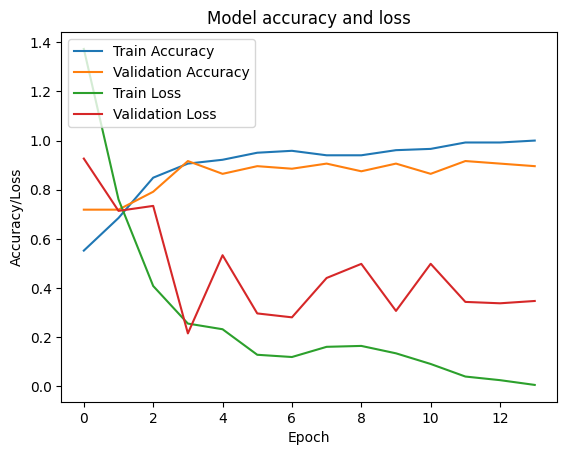

In [14]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy and loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

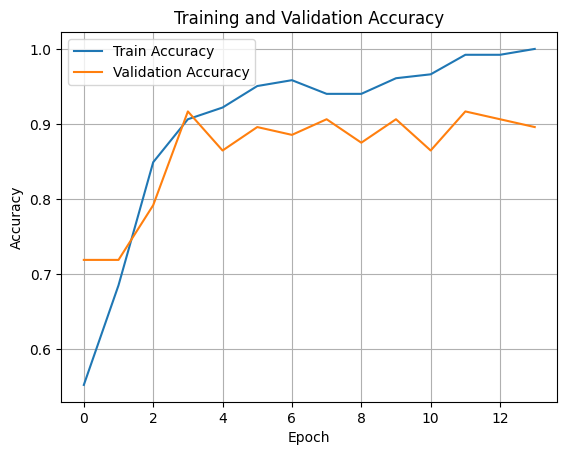

In [15]:
# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Training and Validation Accuracy')  # Title of the plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Add a legend to specify which line is which
plt.grid(True)  # Add grid for better readability
plt.show()  # Display the plot

# Unfreeze Layers and Fine-Tune the Model

In [16]:
# # Unfreeze the last few layers and fine-tune the model
# unfreeze_layers = 3  # Unfreeze the last 3 layers
# for layer in model.layers[-unfreeze_layers:]:
#     layer.trainable = True

# # Recompile the model
# model.compile(optimizer=Adam(learning_rate=best_learning_rate / 10),  # Lower learning rate for fine-tuning
#               loss=CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [17]:
# # Fine-tune the model
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=50,
#     validation_data=test_generator,
#     validation_steps=test_generator.samples // test_generator.batch_size,
#     callbacks=[checkpoint, early_stopping, reduce_lr],
#     class_weight=class_weights
# )

# # Save the fine-tuned model
# model.save(model_file)

In [18]:
# # Plotting the fine-tuning training history
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Fine-tuning Model accuracy and loss')
# plt.ylabel('Accuracy/Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
# plt.show()

In [19]:
# # Plotting training and validation accuracy
# plt.plot(history.history['accuracy'], label='Train Accuracy')  # Plot training accuracy
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
# plt.title('Training and Validation Accuracy')  # Title of the plot
# plt.xlabel('Epoch')  # X-axis label
# plt.ylabel('Accuracy')  # Y-axis label
# plt.legend()  # Add a legend to specify which line is which
# plt.grid(True)  # Add grid for better readability
# plt.show()  # Display the plot

In [20]:
# # Validate the model with test data

# # loaded_model = keras.models.load_model(model_file, safe_mode=False)
# # loaded_model.evaluate(test_generator)

# # Validate and predict
# model = tf.keras.models.load_model(model_file, custom_objects={'VitLayer': vit.vit_b16}, compile=False, safe_mode=False)
# model.compile(optimizer=Adam(learning_rate=best_learning_rate),  # Recompile with the best learning rate
#               loss=CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])


# # Evaluate the model
# model.evaluate(test_generator)

# # Predict the output
# predictions = model.predict(test_generator)
# predictions = np.argmax(predictions, axis=1)

# # Predict and Display image using matplotlib
# plt.figure(figsize=(20, 20))
# for i in range(9):
#     plt.subplot(3, 3, i + 1)
#     for X_batch, Y_batch in test_generator:
#         image = X_batch[0]
#         # Print Class
#         plt.title("Predicted: " + classes[predictions[i]] + "\nActual: " + classes[np.argmax(Y_batch[i])])

#         plt.imshow(image)
#         break

**Model Visualisation (Evaluation)**

6/6 [==============================] - 4s 103ms/step


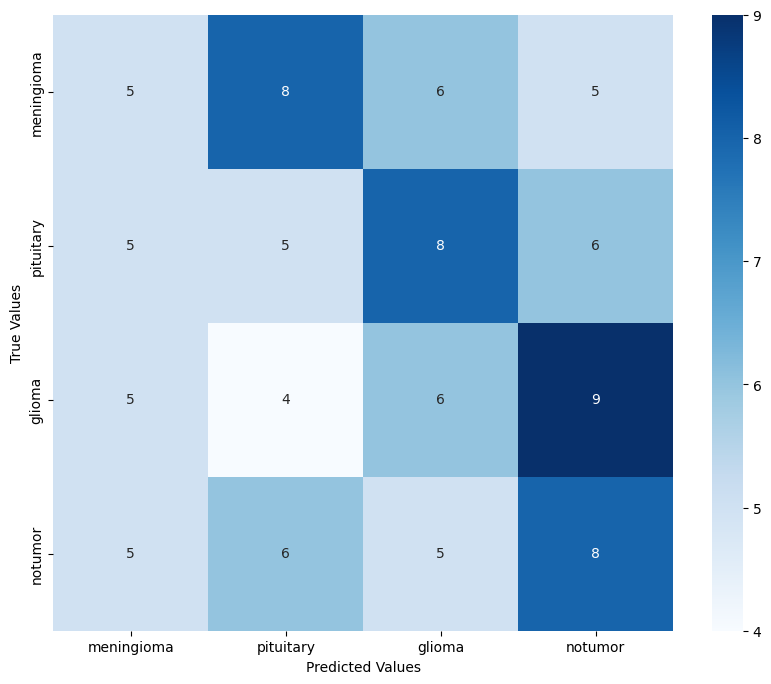

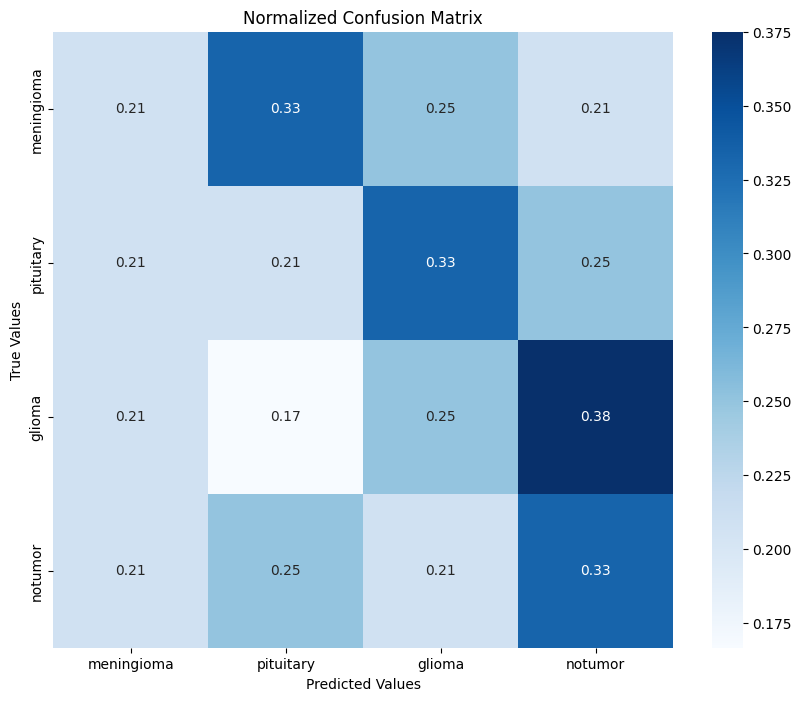

DSC: 0.24815723789887922, Sensitivity: 0.25, Specificity: 0.75, Accuracy: 0.25


In [21]:
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(test_generator.classes, predictions)
# sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
# plt.xlabel('Predicted Values')
# plt.ylabel('True Values');


import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

classes = ['meningioma', 'pituitary', 'glioma', 'notumor']

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.show()

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Predict the output
predictions_prob = model.predict(test_generator)
predictions = np.argmax(predictions_prob, axis=1)

dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")
